In [ ]:
from google.colab import drive
drive.mount('/content/drives')

Drive already mounted at /content/drives; to attempt to forcibly remount, call drive.mount("/content/drives", force_remount=True).


In [ ]:
!pip install tensorflow==2.13.0
!pip install Pillow


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import os
import hashlib
from PIL import Image

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

Cleaning the Data

In [ ]:
def remove_duplicate_images(image_folder):
    unique_images = set()
    duplicates = []

    for filename in os.listdir(image_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(image_folder, filename)
            with Image.open(file_path) as img:
                # Menghitung hash dari gambar
                img_hash = hashlib.md5(img.tobytes()).hexdigest()
                print(f'Processing {filename} with hash: {img_hash}')
                # Debugging
                if img_hash in unique_images:
                    duplicates.append(file_path)
                else:
                    unique_images.add(img_hash)

    # Menampilkan gambar duplikat sebelum menghapus
    if duplicates:
        print("Gambar duplikat yang akan dihapus:")
        for duplicate in duplicates:
            print(duplicate)
    else:
        print("Tidak ada gambar duplikat ditemukan.")


def remove_corrupted_images(image_folder):
    for filename in os.listdir(image_folder):
        file_path = os.path.join(image_folder, filename)
        # Pastikan hanya memproses file gambar
        if os.path.isfile(file_path) and filename.endswith(('.png', '.jpg', '.jpeg')):
            try:
                img = Image.open(file_path)
                img.verify()  # Verifikasi apakah gambar dapat dibaca
            except (IOError, SyntaxError) as e:
                print(f'Deleted corrupted image: {file_path}')
                os.remove(file_path)


In [ ]:
# Remove duplicate dan corrupted images
image_folder = "/content/drives/MyDrive/Skin Disease/IMG_CLASSES"
remove_duplicate_images(image_folder)
remove_corrupted_images(image_folder)

Tidak ada gambar duplikat ditemukan.


Loading and Preprocessing the data

In [ ]:
count = 0
base_path = "/content/drives/MyDrive/Skin Disease/IMG_CLASSES/"
dirs = os.listdir(base_path)

for dir in dirs:
    # Pastikan ada "/" untuk menggabungkan base_path dengan folder
    dir_path = os.path.join(base_path, dir)
    files = os.listdir(dir_path)  # Ambil semua file dalam direktori
    print(f"{dir} Folder has {len(files)} images")  # Tampilkan jumlah file dalam folder
    count += len(files)

print(f"Total Images are {count} images")  # Jumlah total semua gambar


Eczema  Folder has 1000 images
Melanoma  Folder has 2000 images
Atopic Dermatitis  Folder has 1000 images
Basal Cell Carcinoma (BCC)  Folder has 1000 images
Melanocytic Nevi (NV)  Folder has 2000 images
Total Images are 7000 images


In [ ]:
base_dir = '/content/drives/MyDrive/Skin Disease/IMG_CLASSES'
img_size = 180
batch = 16

In [ ]:
#define the path and split your data into training and validation split
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    batch_size=batch,
    seed=123,
    image_size=(img_size, img_size))
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    batch_size=batch,
    seed=123,
    image_size=(img_size, img_size))


Found 7000 files belonging to 5 classes.
Using 5600 files for training.
Found 7000 files belonging to 5 classes.
Using 1400 files for validation.


In [ ]:
skindisease_names = ds_train.class_names
skindisease_names

['Atopic Dermatitis ',
 'Basal Cell Carcinoma (BCC) ',
 'Eczema ',
 'Melanocytic Nevi (NV) ',
 'Melanoma ']

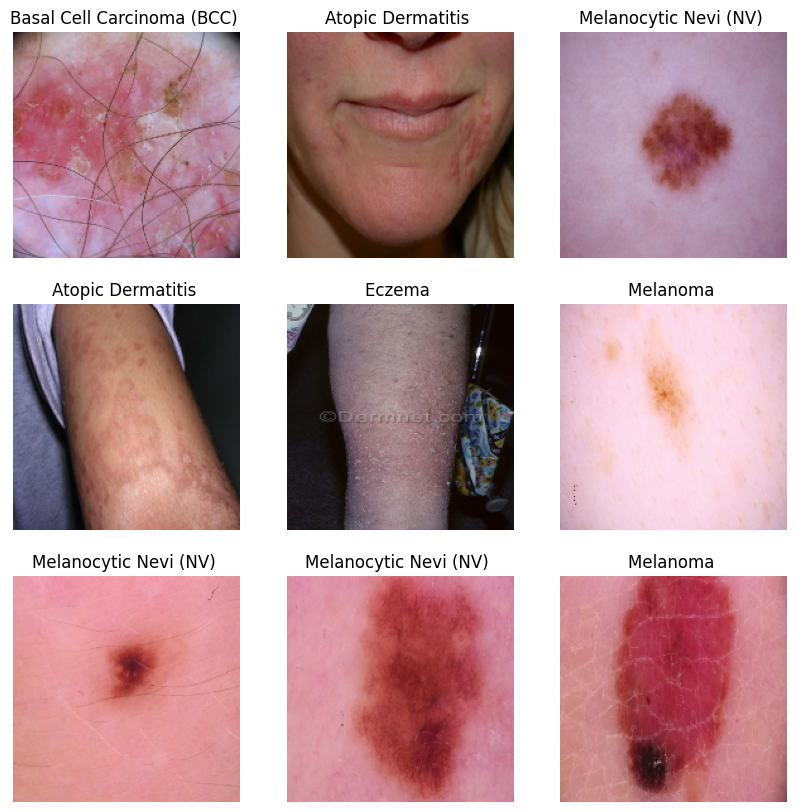

In [ ]:
# Display the first 9 images before normalizing
i = 0
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(skindisease_names[labels[i]])
        plt.axis("off")


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
ds_validation = ds_validation.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Data Augmentation
data_augmentation = Sequential([
        layers.RandomFlip("horizontal", input_shape = (img_size, img_size, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
])

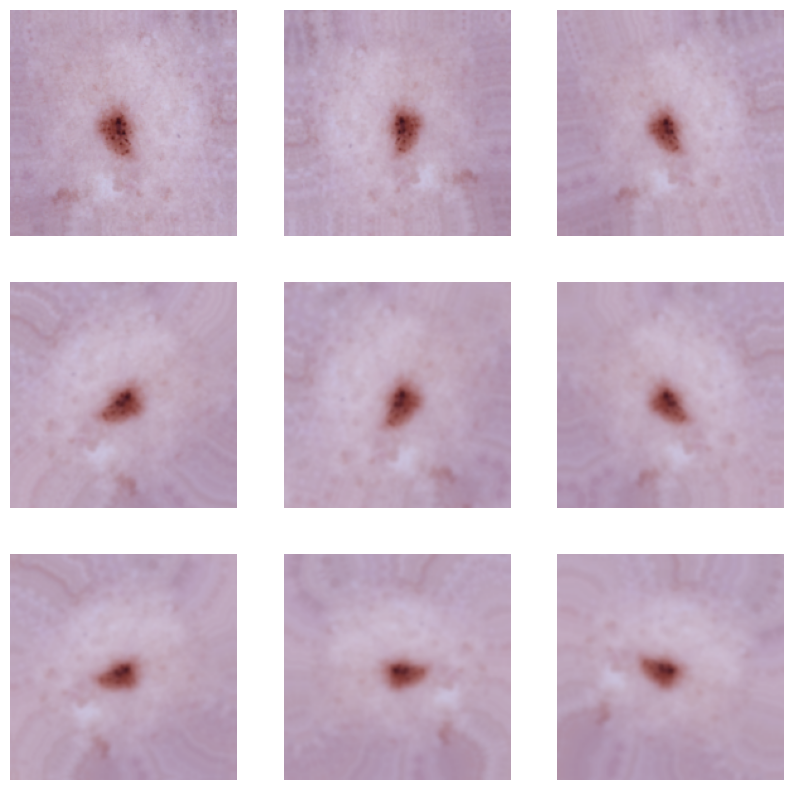

In [ ]:
i = 0
plt.figure(figsize=(10, 10))

for images, labels in ds_train.take(1):
    for i in range(9):
        images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")


Create the Model

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(16, 3, padding ='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding ='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64 , 3, padding ='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])



In [ ]:
#compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Print Model Layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


In [ ]:
#Fit the model
history = model.fit(
    ds_train,
    validation_data=ds_validation,
    epochs=15,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/15
350/350 [==============================] - 484s 1s/step - loss: 0.9598 - accuracy: 0.6011 - val_loss: 0.7384 - val_accuracy: 0.6993 - lr: 0.0010
Epoch 2/15
350/350 [==============================] - 237s 677ms/step - loss: 0.7415 - accuracy: 0.6996 - val_loss: 0.6229 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 3/15
350/350 [==============================] - 228s 649ms/step - loss: 0.6779 - accuracy: 0.7327 - val_loss: 0.5872 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 4/15
350/350 [==============================] - 224s 638ms/step - loss: 0.6329 - accuracy: 0.7484 - val_loss: 0.6133 - val_accuracy: 0.7343 - lr: 0.0010
Epoch 5/15
350/350 [==============================] - 247s 707ms/step - loss: 0.6048 - accuracy: 0.7593 - val_loss: 0.5480 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 6/15
350/350 [==============================] - 227s 650ms/step - loss: 0.5743 - accuracy: 0.7659 - val_loss: 0.5506 - val_accuracy: 0.7686 - lr: 0.0010
Epoch 7/15
350/350 [=============================

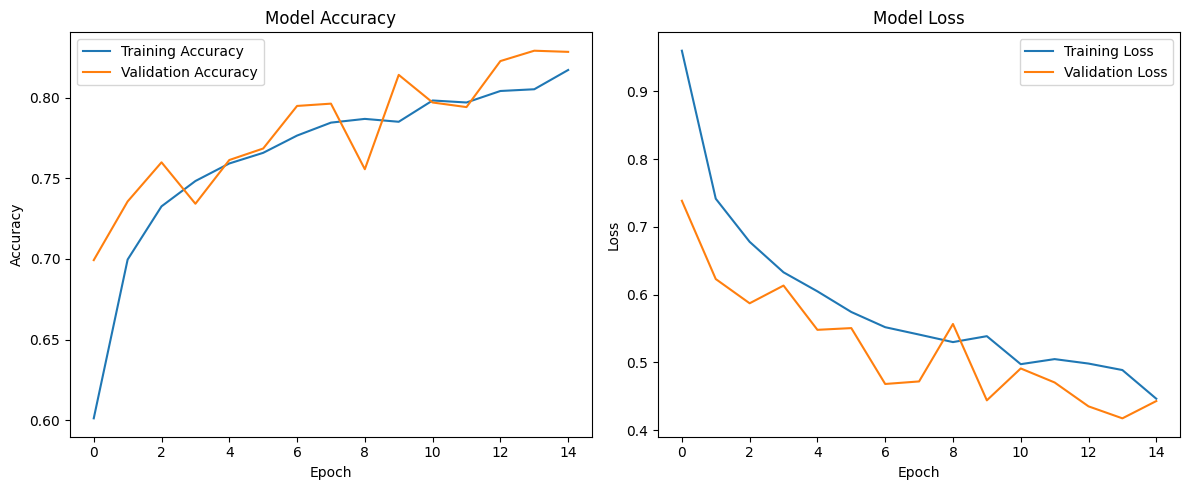

In [ ]:
history = model.history.history

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 150ms/step


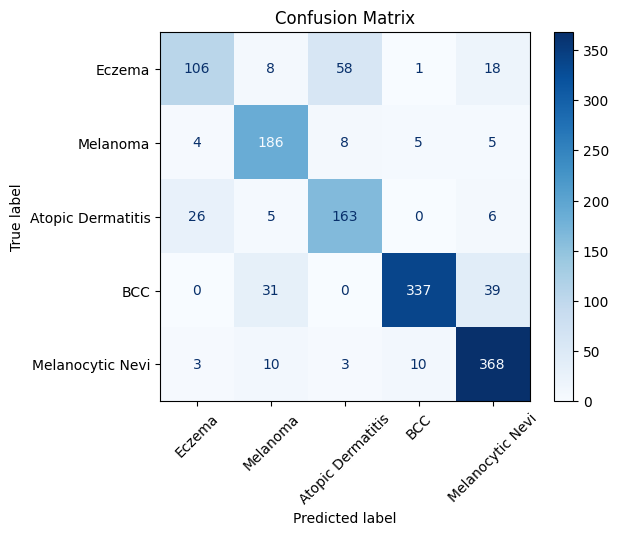

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Asumsi: model sudah dilatih, dan ds_test adalah dataset pengujian
# Langkah 1: Prediksi hasil model pada dataset pengujian
y_true = []
y_pred = []

for images, labels in ds_validation:  # Loop melalui batch dalam dataset pengujian
    predictions = model.predict(images)  # Prediksi dengan model
    y_true.extend(labels.numpy())  # Menambahkan label asli
    y_pred.extend(np.argmax(predictions, axis=1))  # Menambahkan prediksi model (kelas dengan probabilitas tertinggi)

# Konversi hasil menjadi array numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Langkah 2: Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)
skindisease_names = ['Eczema', 'Melanoma', 'Atopic Dermatitis', 'BCC', 'Melanocytic Nevi']  # Ganti dengan nama kelas Anda

# Langkah 3: Menampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=skindisease_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_array = input_image_array / 255.0  # Normalisasi (jika digunakan dalam training)
    input_image_exp_dim = tf.expand_dims(input_image_array, 0)

    prediction = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(prediction[0])

    outcome = (
        "The image belongs to " + skindisease_names[np.argmax(result)] +
        " with a score of " + str(np.max(result)*100)
    )
    return outcome


In [ ]:
classify_images("/content/drives/MyDrive/Skin Disease/IMG_CLASSES/Atopic Dermatitis /0_1.jpg")

1/1 [==============================] - 0s 119ms/step


'The image belongs to Atopic Dermatitis with a score of 40.10196924209595'

In [ ]:
#Save the model architecture to a JSON file
model_json = model.to_json()
with open("SkinDisease_MyModel.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved as JSON.")


Model architecture saved as JSON.


In [ ]:
#Save the model weights to an HDF5 file
model.save_weights("skindisease_mymodel_weights.h5")
print("Model weights have been saved.")


Model weights have been saved.


In [ ]:
#Save the model as a Keras file
model.save("skindisease_model.keras")
print("Model weights saved keras.")


Model weights saved keras.


In [ ]:
from google.colab import files
# Unduh file JSON
files.download("SkinDisease_MyModel.json")
files.download("skindisease_mymodel_weights.h5")
files.download("skindisease_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>